In [1]:
from __future__ import division, print_function, absolute_import
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Training Parameters
learning_rate = 0.001
num_steps = 50000
batch_size = 256

display_step = 100
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

#truncated_normal效果优于random_normal
weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([num_input, num_hidden_1],stddev=0.1)),
    'encoder_h2': tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2],stddev=0.1)),
    'decoder_h1': tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_1],stddev=0.1)),
    'decoder_h2': tf.Variable(tf.truncated_normal([num_hidden_1, num_input],stddev=0.1)),
}
biases = {
    'encoder_b1': tf.Variable(tf.truncated_normal([num_hidden_1],stddev=0.1)),
    'encoder_b2': tf.Variable(tf.truncated_normal([num_hidden_2],stddev=0.1)),
    'decoder_b1': tf.Variable(tf.truncated_normal([num_hidden_1],stddev=0.1)),
    'decoder_b2': tf.Variable(tf.truncated_normal([num_input],stddev=0.1)),
}

In [4]:
# Building the encoder
#sigmod效果优于relu
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [5]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)

if(os.path.exists("/notebooks/AutoEncoder/checkpoint") == False):  
    print("begin to train...")

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

    saver_path = saver.save(sess, "/notebooks/AutoEncoder/autoencoder_model.ckpt")  # 保存模型

else:
   print("restore the model...")
   saver.restore(sess,'/notebooks/AutoEncoder/autoencoder_model.ckpt') 

restore the model...
INFO:tensorflow:Restoring parameters from /notebooks/AutoEncoder/autoencoder_model.ckpt


Original Images


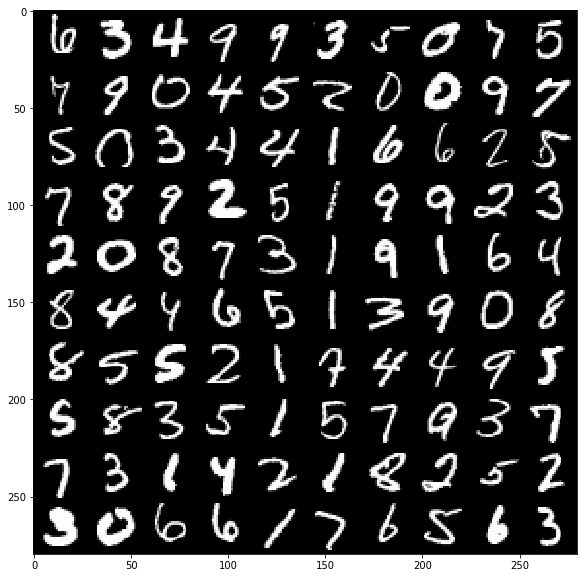

Reconstructed Images


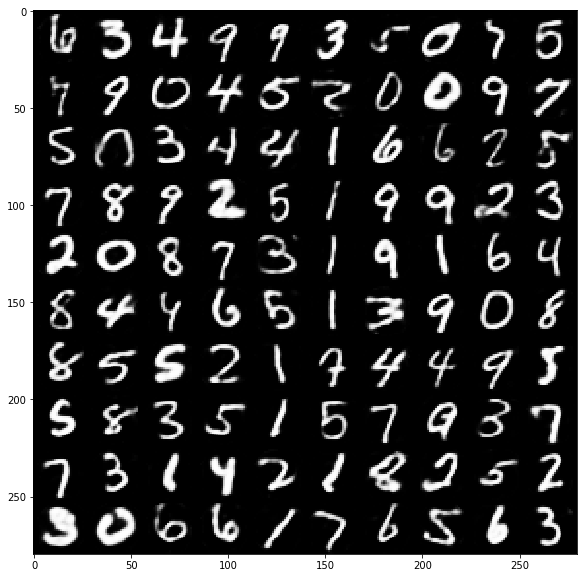

In [6]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 10
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i in range(n):
    # MNIST test set
    batch_x, _ = mnist.test.next_batch(n)
    batch_x, _ = mnist.test.next_batch(n)
    batch_x, _ = mnist.test.next_batch(n)
    batch_x, _ = mnist.test.next_batch(n)
    # Encode and decode the digit image
    g = sess.run(decoder_op, feed_dict={X: batch_x})
    
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
    # Display reconstructed images
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()